In [19]:
### time series forecasting 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from src import config

pd.set_option("display.max_columns", None)


In [20]:
!pip install statsmodels
!pip install xgboost

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
# read in data 
df = pd.read_parquet(config.INT_FILE_PATH / 'transactions.parquet')

In [23]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name,order_total_price,shipping_cost_perc,purchase_dow,late_delivery,delivery_days,days_late,product_size
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture,146.87,0.148975,1,False,8.0,0.0,107136.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC,housewares,335.48,0.138548,4,False,16.0,0.0,53400.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP,office_furniture,157.73,0.112788,5,True,26.0,1.0,45968.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP,office_furniture,173.30,0.134795,1,False,14.0,0.0,79968.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP,home_confort,252.25,0.088206,6,False,11.0,0.0,23625.0


In [24]:
df = df[["order_purchase_timestamp", "order_total_price"]]

In [25]:
weekly_sales = df.set_index("order_purchase_timestamp").resample("W")[["order_total_price"]].sum()

In [26]:
weekly_sales

,order_total_price
order_purchase_timestamp,
2016-09-04,136.23
2016-09-11,75.06
2016-09-18,143.46
2016-09-25,0.00
2016-10-02,109.34
...,...
2018-09-23,0.00
2018-09-30,0.00
2018-10-07,0.00


In [27]:
decompose = seasonal_decompose(weekly_sales, extrapolate_trend=12)

In [10]:
#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
season = decompose.seasonal
#Error
random = decompose.resid


<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='resid'>

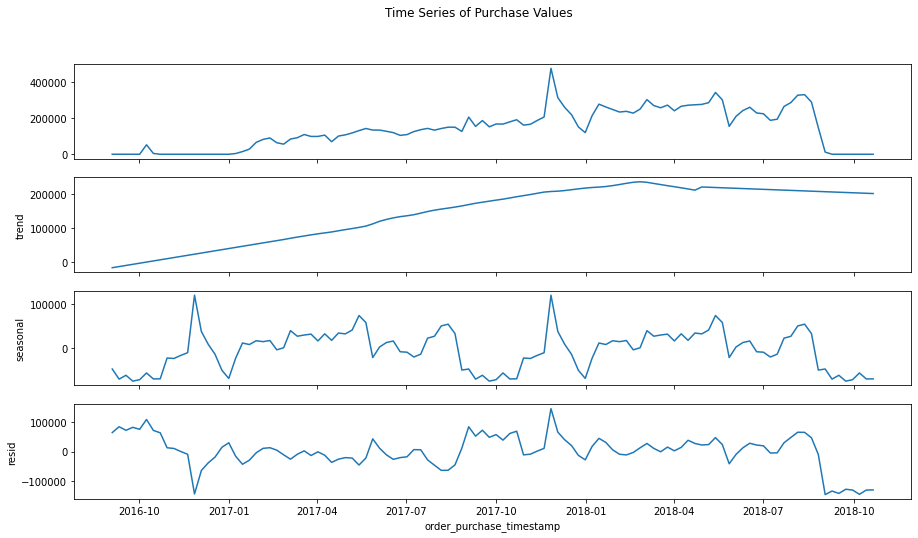

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(15,8), sharex=True)
fig.suptitle('Time Series of Purchase Values')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=season.index, y=season, ax=axes[2], data=season)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

In [12]:
weekly_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 2016-09-04 to 2018-10-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_total_price  112 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [13]:
train_size = int(len(weekly_sales) * 0.80)
train, test = weekly_sales[0:train_size], weekly_sales[train_size:]

In [14]:
for df in [train, test]: 
    df["X"] = df["order_total_price"].shift(1)

/tmp/ipykernel_331/3627600621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["X"] = df["order_total_price"].shift(1)
/tmp/ipykernel_331/3627600621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["X"] = df["order_total_price"].shift(1)


In [15]:
train.head()

,order_total_price,X
order_purchase_timestamp,,
2016-09-04,136.23,NaN
2016-09-11,75.06,136.23
2016-09-18,143.46,75.06
2016-09-25,0.00,143.46
2016-10-02,109.34,0.00


In [16]:
X_train, y_train = train[["X"]], train["order_total_price"]
X_test, y_test = test[["X"]], test["order_total_price"]

In [17]:
xgb_model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05)
xgb_model.fit(X_train, y_train, 
        early_stopping_rounds=5, 
        eval_set=[(X_test, y_test)], 
        verbose=False)

xgb_pred = xgb_model.predict(X_test)

print('RMSE for xgb was: \n', mean_squared_error(y_test, xgb_pred, squared=False))

/root/miniconda3/envs/dsb/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE for xgb was: 
 84558.53357816084


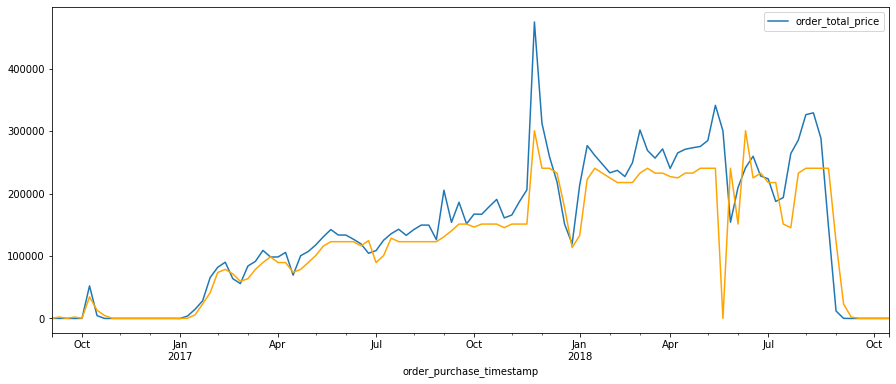

In [18]:

train_pred = pd.Series(xgb_model.predict(X_train))
test_pred = pd.Series(xgb_model.predict(X_test))

predictions = pd.concat([train_pred, test_pred], axis=0)
predictions.index = weekly_sales.index

ax = plt.gca()

weekly_sales[['order_total_price']].plot(figsize=(15, 6), ax=ax)
predictions.plot(figsize=(15, 6), ax=ax, color="orange")
plt.show()